/opt/anaconda3/envs/helsedir/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/helsedir/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Initializing Ollama PRIMARY LLM: gemma3:12b
Initializing Ollama Embedding: nomic-embed-text
Ollama Base URL: http://localhost:11434
LlamaIndex Settings configured for Ollama: LLM=gemma3:12b, Embeddings=nomic-embed-text

Initializing Hugging Face Translator LLM: mimir-project/mimir-mistral-7b-core-instruct
This may take some time to download the model weights...
CUDA not available. Mimir model will run on CPU (might be slow). Using default float32.
Hugging Face Translator LLM (mimir-project/mimir-mistral-7b-core-instruct) initialized successfully with max_new_tokens=1024.
Loading existing vector index from: pdf_index_local
Vector index loaded successfully.

Building LangGraph workflow...
Workflow compiled successfully.
Generating graph visualization...


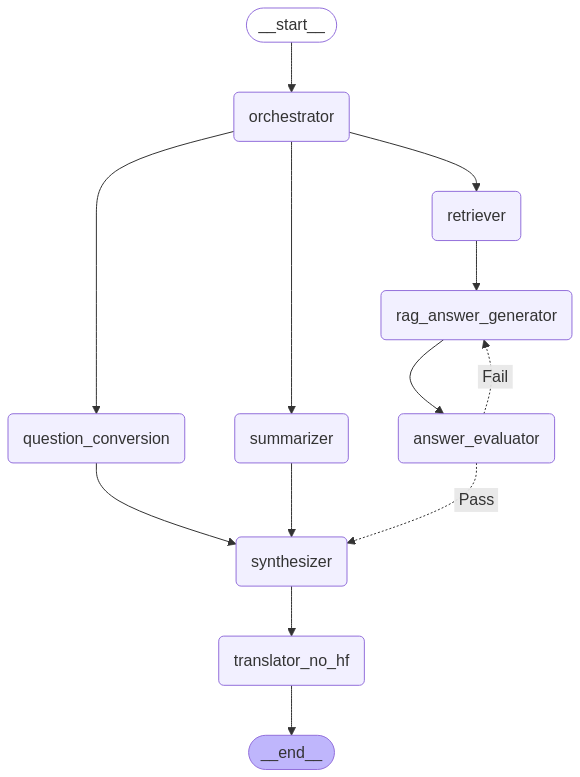

Graph visualization saved to workflow_graph_hf_translation.png.

--- Starting RAG Workflow Execution (Ollama RAG + HF Translation) ---

========== Answering Question (Ollama RAG + HF Translation) ==========
Invoking workflow...

========== Workflow Start ==========
[Orchestrator] Received question: 'What is the main topic discussed in the document?'
[Question Conversion] Starting...
[Question Summary] Starting...
[Retriever] Starting...
[Retriever] Found 3 relevant contexts for query: 'What is the main topic discussed in the document?'
[Question Conversion] Converted question: 'What does the document primarily focus on?'
[Question Summary] Summary: 'The question asks for the central subject or theme explored within the document.'
[Synthesizer] Starting...
[Synthesizer] Evaluation passed: False, Attempts: 0
[Synthesizer] Processing history: ['orchestrator', 'question_conversion', 'retriever', 'summarizer']
[RAG Answer Generator] Starting...
[Synthesizer] Final Answer:
Please provide the

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[RAG Answer Generator] RAG answer (Attempt 1): 'Based on the provided documents, the main topic discussed is the use of language models, such as GPT-4, to assist in producing content that aligns with standards like the Common European Framework of ...'
[Translator NO - HF] Starting translation using mimir-project/mimir-mistral-7b-core-instruct via HuggingFaceLLM...
[Translator NO - HF] Calling Mimir model (mimir-project/mimir-mistral-7b-core-instruct)...
[Answer Evaluator] Starting...
[Answer Evaluator] Score: 9.0, Attempt: 1, Passed? True
[Translator NO - HF] Norwegian Translation (processed snippet): --- Norwegian (Bokmål) Text ---
--- Detailed Answer ---

--- End Detailed Answer ---

--- Norwegian (Bokmål) Translation ---

--- End Norwegian (Bokmål) Translation ---

--- English Text ---
Please pr...
[Synthesizer] Starting...
[Synthesizer] Evaluation passed: True, Attempts: 1
[Synthesizer] Processing history: ['orchestrator', 'question_conversion', 'retriever', 'summarizer', 'rag_gen

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Synthesizer] Final Answer:
The document focuses on utilizing language models, such as GPT-4, to aid in the creation of content that meets established standards like the Common European Framework of Reference for Languages (CEFR) and the Common Core Standards (CCS). This involves assessing content complexity through linguistic flags (e.g., sentence length, conjunction count, readability scores) and aligning it with specific levels defined within these frameworks. While the approach primarily addresses the English language, the study anticipates minimal ethical concerns and emphasizes that language models serve as an assistive tool rather than a replacement for expert content creation.
[Translator NO - HF] Starting translation using mimir-project/mimir-mistral-7b-core-instruct via HuggingFaceLLM...
[Translator NO - HF] Calling Mimir model (mimir-project/mimir-mistral-7b-core-instruct)...
[Translator NO - HF] Norwegian Translation (processed snippet): --- Norwegian (Bokmål) Text ---
Doku

In [1]:
# This notebook implements a Retrieval-Augmented Generation (RAG) system
# using LangGraph and LlamaIndex.
# It uses a local primary LLM via Ollama (e.g., Gemma) for core RAG tasks.
# It ingests data from PDF files in a specified directory.
# Includes a final step to translate the answer to Norwegian using
# the Mimir model loaded directly from Hugging Face Hub.

## Workflow Architecture
# 1. Orchestrator: Initiates workflow.
# 2. Question Processing (Parallel): Conversion, Summary, Retrieval (uses Ollama LLM/Embeddings).
# 3. RAG Generation: Creates answer from context (uses Ollama LLM).
# 4. Quality Evaluation: Rates answer (uses Ollama LLM).
# 5. Synthesis: Creates final English answer (uses Ollama LLM).
# 6. Translation: Translates to Norwegian using Mimir model via Hugging Face transformers. <--- NEW METHOD

## Key Components
# - Vector Store: Stores PDF embeddings (local Ollama embeddings).
# - Primary LLM (Ollama): Used for core RAG, evaluation, synthesis.
# - Translation LLM (Hugging Face): Mimir model loaded directly for translation.
# - Parallel Processing, Quality Control, Fallbacks.

## Usage
# Run answer_question("Your question here") to process a query.

# --- Prerequisites ---
# 1. Install Ollama: https://ollama.com/
# 2. Pull required Ollama models:
#    ollama pull gemma3:12b      # Or your specific primary LLM for Ollama
#    ollama pull nomic-embed-text # Or your chosen embedding model
#    # --- Mimir is now loaded via Hugging Face, no Ollama pull needed for it ---
# 3. Install Python libraries:
#    pip install llama-index langgraph llama-index-llms-ollama llama-index-embeddings-ollama ipython pypdf
#    pip install llama-index-llms-huggingface # LlamaIndex HF integration 
#    pip install transformers torch accelerate # Core Hugging Face libs 
#    # Optional, but recommended for memory efficiency:
#    # pip install bitsandbytes # For 4-bit/8-bit quantization (Optional)
# 4. Create Data Directory: Create "data" folder.
# 5. Add PDF: Place PDF file(s) inside "data".
# 6. Resources: Ensure sufficient RAM/VRAM for loading the Mimir model directly.
# ---------------------

import os
from typing_extensions import TypedDict, Annotated
from typing import List
import operator
import re
from IPython.display import Image, display
import warnings # To suppress potential warnings

# Suppress specific warnings if they appear during model loading
warnings.filterwarnings("ignore", message=".*TorchScript is not supported.*")

# --- LangGraph and LlamaIndex Core Imports ---
from langgraph.graph import StateGraph, START, END
from llama_index.core import (
    VectorStoreIndex, Document, StorageContext, load_index_from_storage, Settings,
    SimpleDirectoryReader, PromptTemplate # Added PromptTemplate
)
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core.node_parser import SentenceSplitter

# --- Ollama Imports ---
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding

# --- Hugging Face Imports ---
try:
    import torch # Required for HuggingFaceLLM
    from llama_index.llms.huggingface import HuggingFaceLLM
    # Check if bitsandbytes is available for quantization
    try:
        import bitsandbytes
        BITSANDBYTES_AVAILABLE = True
    except ImportError:
        BITSANDBYTES_AVAILABLE = False
        print("Warning: bitsandbytes not installed. Will not use 4-bit quantization for Mimir model.")
    HUGGINGFACE_AVAILABLE = True
except ImportError:
    print("Error: Hugging Face libraries ('torch', 'transformers', 'accelerate', 'llama-index-llms-huggingface') not found.")
    print("Please install them: pip install llama-index-llms-huggingface transformers torch accelerate")
    print("Optionally install bitsandbytes for quantization: pip install bitsandbytes")
    HUGGINGFACE_AVAILABLE = False
    # Define a placeholder if import fails to avoid crashing later checks
    class HuggingFaceLLM: pass


# --- Configuration ---
PRIMARY_LLM_MODEL_OLLAMA = "gemma3:12b" # Ollama model for main tasks
LOCAL_EMBEDDING_MODEL_OLLAMA = "nomic-embed-text" # Ollama embedding model
OLLAMA_BASE_URL = "http://localhost:11434"
#Hugging Face model for translation
MIMIR_TRANSLATION_MODEL_HF = "mimir-project/mimir-mistral-7b-core-instruct"
REQUEST_TIMEOUT = 180.0
DATA_DIRECTORY = "data"
VECTOR_INDEX_PATH = "pdf_index_local"

# Define state
class WorkflowState(TypedDict):
    original_question: str
    converted_question: str
    question_summary: str
    retrieved_contexts: List[str]
    rag_answer: str
    evaluation_passed: bool
    attempt_count: int
    final_answer: str
    translated_norwegian_answer: str
    processed: Annotated[List[str], operator.add]


# --- Initialize Ollama Components and LlamaIndex Settings ---
def initialize_ollama_components():
    """Initialize Ollama LLM and Embedding clients."""
    print(f"Initializing Ollama PRIMARY LLM: {PRIMARY_LLM_MODEL_OLLAMA}")
    print(f"Initializing Ollama Embedding: {LOCAL_EMBEDDING_MODEL_OLLAMA}")
    print(f"Ollama Base URL: {OLLAMA_BASE_URL}")

    # Primary LLM (Ollama) for main tasks
    primary_llm_ollama = Ollama(
        model=PRIMARY_LLM_MODEL_OLLAMA,
        base_url=OLLAMA_BASE_URL,
        request_timeout=REQUEST_TIMEOUT,
        temperature=0.0,
    )

    embed_model_ollama = OllamaEmbedding(
        model_name=LOCAL_EMBEDDING_MODEL_OLLAMA,
        base_url=OLLAMA_BASE_URL,
    )

    # --- Configure LlamaIndex Settings for the PRIMARY Ollama LLM ---
    Settings.llm = primary_llm_ollama
    Settings.embed_model = embed_model_ollama
    Settings.chunk_size = 512
    Settings.chunk_overlap = 20
    print(f"LlamaIndex Settings configured for Ollama: LLM={Settings.llm.model}, Embeddings={Settings.embed_model.model_name}")

    return primary_llm_ollama, embed_model_ollama

# Initialize Ollama components
primary_llm, embed_model = initialize_ollama_components()

# --- Initialize Hugging Face LLM for Translation ---
def initialize_hf_translator_llm():
    """Initialize the Hugging Face LLM for translation."""
    if not HUGGINGFACE_AVAILABLE:
        print("Cannot initialize Hugging Face LLM due to missing libraries.")
        return None

    print(f"\nInitializing Hugging Face Translator LLM: {MIMIR_TRANSLATION_MODEL_HF}")
    print("This may take some time to download the model weights...")

    # --- Define the Prompt Template for Mimir Instruct ---
    mimir_instruct_template = PromptTemplate(
        "[INST] Du er en ekspert oversetter. Oversett følgende engelske teksten nøyaktig og naturlig til norsk (bokmål).\n"
        "Translate the following English text to Norwegian (Bokmål):\n\n"
        "--- English Text ---\n"
        "{query_str}\n"
        "--- End English Text ---\n\n"
        "Norwegian (Bokmål) Translation: [/INST]"
    )

    device_map = "auto"
    quantization_config = None
    torch_dtype = torch.float16

    if torch.cuda.is_available():
        print("CUDA is available. Trying to configure GPU usage.")
        if BITSANDBYTES_AVAILABLE:
            print("bitsandbytes is available. Configuring 4-bit quantization (bnb_4bit).")
            # Assuming 'transformers' is imported if BITSANDBYTES_AVAILABLE is True
            import transformers # Ensure transformers is imported here if needed
            quantization_config = transformers.BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,
            )
            torch_dtype = None # Let BNB handle dtype
        else:
             print("CUDA available, but bitsandbytes not found. Using float16 precision for Mimir.")
             # Keep torch_dtype = torch.float16
    else:
        print("CUDA not available. Mimir model will run on CPU (might be slow). Using default float32.")
        device_map = "cpu"
        torch_dtype = torch.float32

    try:
        hf_translator_llm = HuggingFaceLLM(
            model_name=MIMIR_TRANSLATION_MODEL_HF,
            tokenizer_name=MIMIR_TRANSLATION_MODEL_HF,
            context_window=2048,  # Or adjust if needed based on model card
            # ***** INCREASE THIS VALUE *****
            max_new_tokens=1024,  # Increased from 512 - Adjust if still too short
            # *****************************
            generate_kwargs={"temperature": 0.1, "do_sample": True}, # Fine-tune temp if needed
            query_wrapper_prompt=mimir_instruct_template,
            device_map=device_map,
            model_kwargs={
                "torch_dtype": torch_dtype,
                "quantization_config": quantization_config,
                # Add other relevant model_kwargs if needed, e.g., attn_implementation="flash_attention_2" if supported/installed
            },
        )
        # Update log message to reflect the change
        print(f"Hugging Face Translator LLM ({MIMIR_TRANSLATION_MODEL_HF}) initialized successfully with max_new_tokens=1024.")
        return hf_translator_llm
    except Exception as e:
        print(f"\n---!!! ERROR initializing Hugging Face LLM !!!---")
        print(f"Model: {MIMIR_TRANSLATION_MODEL_HF}")
        print(f"Error: {e}")
        print("Possible reasons:")
        print("- Model name incorrect or model not available on Hugging Face Hub.")
        print("- Insufficient RAM/VRAM. Check resource usage.")
        print("- Missing dependencies (transformers, torch, accelerate).")
        print("- Incorrect quantization setup or incompatible hardware.")
        print("- Network issues preventing model download.")
        print("Translation step will be skipped.")
        print("-----------------------------------------------------\n")
        return None

# Re-initialize the HF Translator LLM instance with the new setting
mimir_hf_llm = initialize_hf_translator_llm()



# --- Vector Store Initialization ---
def initialize_vector_store():
    index_path = VECTOR_INDEX_PATH
    data_dir = DATA_DIRECTORY
    try:
        # Try to load existing index
        if os.path.exists(index_path):
            print(f"Loading existing vector index from: {index_path}")
            storage_context = StorageContext.from_defaults(persist_dir=index_path)
            index = load_index_from_storage(storage_context) # Uses Settings.embed_model
            print("Vector index loaded successfully.")
            return index
        else:
            print(f"No existing index found at {index_path}.")
            print(f"Creating new vector index from documents in: {data_dir}")
            if not os.path.isdir(data_dir):
                print(f"Error: Data directory '{data_dir}' not found.")
                return None
            print(f"Loading documents from '{data_dir}'...")
            reader = SimpleDirectoryReader(input_dir=data_dir)
            documents = reader.load_data(show_progress=True)
            if not documents:
                print(f"Error: No documents were loaded from '{data_dir}'.")
                return None
            print(f"Successfully loaded {len(documents)} document(s).")
            print(f"Using embedding model (from Settings): {Settings.embed_model.model_name}")
            parser = SentenceSplitter() # Uses Settings.chunk_size/overlap
            nodes = parser.get_nodes_from_documents(documents, show_progress=True)
            print(f"Parsed {len(documents)} documents into {len(nodes)} nodes.")
            if not nodes:
                print("Error: Failed to parse any nodes from the documents.")
                return None
            print("Creating vector store index...")
            index = VectorStoreIndex(nodes, show_progress=True) # Uses Settings.embed_model
            print("Vector index created successfully.")
            print(f"Persisting vector index to: {index_path}")
            os.makedirs(index_path, exist_ok=True)
            index.storage_context.persist(persist_dir=index_path)
            print(f"Vector index persisted successfully.")
            return index
    except ImportError:
        print("Error: 'pypdf' library not found. Please install it using: pip install pypdf")
        return None
    except Exception as e:
        print(f"Error initializing vector store: {e}")
        return None

# Initialize the vector index
vector_index = initialize_vector_store()


# --- call_llm function (Uses the PRIMARY OLLAMA LLM by default - Unchanged) ---
def call_llm(prompt: str, system_prompt: str = "You are a helpful assistant that provides clear, concise responses.") -> str:
    """ Call the local PRIMARY OLLAMA LLM (from Settings) via .chat interface. """
    try:
        messages = [
            ChatMessage(role=MessageRole.SYSTEM, content=system_prompt),
            ChatMessage(role=MessageRole.USER, content=prompt)
        ]
        response = Settings.llm.chat(messages) # Uses primary Ollama LLM via Settings
        return response.message.content
    except Exception as e:
        print(f"Error calling local Ollama LLM ({Settings.llm.model}): {e}")
        if "Convert the following question" in prompt: return "How do you make a soft and moist chocolate cake? (Fallback)"
        elif "Summarize this question" in prompt: return "Recipe for a moist chocolate cake (Fallback)"
        elif "Based on available knowledge" in prompt: return "To bake a perfect chocolate cake you need: [Fallback Ingredients]"
        elif "Evaluate the following answer" in prompt: return "5"
        else: return f"[ERROR] Failed to get response from local Ollama LLM: {e}"


# --- retrieve_relevant_contexts function (Unchanged - uses Ollama Embeddings via Settings) ---
def retrieve_relevant_contexts(query: str, top_k: int = 3) -> List[str]:
    """ Retrieve relevant contexts from the vector store based on query """
    try:
        if vector_index is None:
            print("Vector index not available. Using fallback.")
            return ["No vector index available. Using general knowledge."]
        retriever = vector_index.as_retriever(similarity_top_k=top_k)
        retrieval_results = retriever.retrieve(query)
        contexts = [node.node.text for node in retrieval_results]
        print(f"[Retriever] Found {len(contexts)} relevant contexts for query: '{query}'")
        return contexts
    except Exception as e:
        print(f"Error during retrieval: {e}")
        return ["Error retrieving information. Using general knowledge instead."]

# --- LangGraph Nodes (Existing nodes using Ollama LLM via Settings remain unchanged) ---

def orchestrator(state: WorkflowState) -> dict:
    question = state["original_question"]
    print(f"\n{'='*10} Workflow Start {'='*10}")
    print(f"[Orchestrator] Received question: '{question}'")
    return {"attempt_count": 0, "processed": ["orchestrator"]}

def question_conversion(state: WorkflowState) -> dict:
    question = state["original_question"]
    print("[Question Conversion] Starting...")
    prompt = (f"Convert the following question to another form: {question}\nKeep it concise and precise.")
    converted = call_llm(prompt) # Uses Ollama
    print(f"[Question Conversion] Converted question: '{converted}'")
    return {"converted_question": converted, "processed": ["question_conversion"]}

def question_summary(state: WorkflowState) -> dict:
    question = state["original_question"]
    print("[Question Summary] Starting...")
    prompt = (f"Summarize this question in one sentence: {question}\nFocus on the core message.")
    summary = call_llm(prompt) # Uses Ollama
    print(f"[Question Summary] Summary: '{summary}'")
    return {"question_summary": summary, "processed": ["summarizer"]}

def retrieval_step(state: WorkflowState) -> dict:
    question = state["original_question"]
    print("[Retriever] Starting...")
    contexts = retrieve_relevant_contexts(question)
    return {"retrieved_contexts": contexts, "processed": ["retriever"]}

def rag_answer_generator(state: WorkflowState) -> dict:
    """Generates an answer using RAG approach with retrieved contexts (from PDF)"""
    print("[RAG Answer Generator] Starting...")
    question = state["original_question"]
    contexts = state.get("retrieved_contexts", [])
    attempt_count = state.get("attempt_count", 0) # Get attempt count for context

    # System prompt for RAG (emphasize using ONLY provided context)
    rag_system_prompt = "You are a helpful assistant that provides clear, concise answers based ONLY on the provided context information retrieved from documents. If the context doesn't contain the answer, clearly state that the provided documents do not contain the necessary information."

    # Create chat template for RAG
    chat_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=rag_system_prompt)
    ]

    # If no contexts were retrieved or an error occurred
    if not contexts or contexts[0].startswith("Error") or contexts[0].startswith("No vector"):
        print("[RAG Answer Generator] No valid contexts found from PDF index. Indicating failure.")
        prompt = (
            f"The user asked: '{question}'. "
            "However, no relevant information could be retrieved from the provided documents. "
            "State that you cannot answer based on the available document content."
        )
        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))
    else:
        # Format contexts into the prompt
        context_text = "\n\n".join([f"Context {i+1}:\n{ctx}" for i, ctx in enumerate(contexts)])
        prompt = (
            f"Based ONLY on the following information extracted from the provided documents, provide a detailed answer to the user's question.\n\n"
            f"--- Context Information ---\n{context_text}\n--- End Context ---\n\n"
            f"User Question: {question}\n\n"
            "Use ONLY the information from the contexts above. Do not add outside knowledge. "
            "If the contexts do not provide enough information to answer fully, state that clearly. "
            "Be detailed and informative based *only* on what is available in the context."
        )
        # Modify prompt slightly on retries if needed
        if attempt_count > 0:
             prompt += f"\n(Attempt {attempt_count + 1}: Please re-evaluate the context carefully based *only* on the text provided.)"

        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))

    # Use the LLM to generate a response
    response = Settings.llm.chat(chat_messages)
    answer = response.message.content
    print(f"[RAG Answer Generator] RAG answer (Attempt {attempt_count + 1}): '{answer[:200]}...'") # Print snippet
    return {
        "rag_answer": answer,
        "processed": ["rag_generator"]
    }

def answer_evaluator(state: WorkflowState) -> dict:
    """Evaluates the answer quality using the local LLM"""
    print("[Answer Evaluator] Starting...")
    rag_answer = state['rag_answer']
    # Get or initialize attempt counter
    attempt_count = state.get("attempt_count", 0) + 1

    # Create evaluation prompt (English)
    eval_system_prompt = "You are a quality evaluator. Rate the clarity, relevance, and faithfulness to the provided context of the following answer on a scale from 0 to 10. Respond ONLY with the number (e.g., '8')."
    eval_prompt = (
        "Evaluate the following answer based on its clarity, relevance to the likely user question, and how well it sticks to information likely found in source documents (avoiding outside knowledge). "
        "Score 0-10. Respond ONLY with the number.\n\n"
        f"Answer: {rag_answer}"
    )

    # Use chat message format for evaluation
    eval_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=eval_system_prompt),
        ChatMessage(role=MessageRole.USER, content=eval_prompt)
    ]

    # Get evaluation score
    eval_score = 0.0 # Default score
    try:
        # Use the globally configured llm from Settings
        eval_response = Settings.llm.chat(eval_messages)
        eval_score_str = eval_response.message.content.strip()

        # Extract the first number found in the response
        number_match = re.search(r'(\d+(?:\.\d+)?)', eval_score_str)
        if number_match:
            eval_score = float(number_match.group(1))
            # Clamp score between 0 and 10
            eval_score = min(max(eval_score, 0.0), 10.0)
        else:
            print(f"[Answer Evaluator] Could not parse score from response: '{eval_score_str}'. Defaulting to 0.")
            eval_score = 0.0 # Assign default if parsing fails

    except Exception as e:
        print(f"Error during LLM call in evaluation: {e}")
        eval_score = 0.0 # Default score on error

    # Pass if score >= 5.0 OR we've already tried 3 times
    evaluation_passed = (eval_score >= 5.0) or (attempt_count >= 3)
    print(f"[Answer Evaluator] Score: {eval_score}, Attempt: {attempt_count}, Passed? {evaluation_passed}")

    return {
        "evaluation_passed": evaluation_passed,
        "attempt_count": attempt_count, # Pass the updated count
        "processed": ["evaluator"]
    }
    
def synthesizer(state: WorkflowState) -> dict:
    """Combines all components into a final answer using the local LLM"""
    print("[Synthesizer] Starting...")
    # Get components from state
    original_question = state.get("original_question", "N/A")
    converted = state.get("converted_question", "N/A")
    summary = state.get("question_summary", "N/A")
    answer = state.get("rag_answer", "N/A")
    attempts = state.get("attempt_count", 0)
    processed = state.get("processed", [])
    eval_passed = state.get("evaluation_passed", False)

    print(f"[Synthesizer] Evaluation passed: {eval_passed}, Attempts: {attempts}")
    print(f"[Synthesizer] Processing history: {processed}")

    # Create synthesizer prompt using chat template
    synth_system_prompt = "You are an expert synthesizer. Combine the provided information into a single, final, well-structured response for the user, based *only* on the detailed answer derived from source documents. Be concise and professional."
    synth_prompt = (
        "Synthesize the following information into a final answer for the user. "
        "Focus *exclusively* on the 'Detailed Answer' which was generated based on retrieved document context. "
        "Ignore the reformulated question and summary if they contradict the detailed answer. "
        "Present the final answer clearly and professionally.\n\n"
        f"Original Question: {original_question}\n"
        f"Question Reformulated: {converted}\n" # Context only
        f"Question Summary: {summary}\n" # Context only
        f"Detailed Answer (derived from documents, after {attempts} attempts, evaluation passed: {eval_passed}):\n{answer}\n\n"
        "--- Final Synthesized Response (Based ONLY on Detailed Answer) ---"
    )

    synthesis_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=synth_system_prompt),
        ChatMessage(role=MessageRole.USER, content=synth_prompt)
    ]

    # Use LLM for final synthesis
    final_answer = "Error during synthesis." # Default
    try:
        # Use the globally configured llm from Settings
        synthesis_response = Settings.llm.chat(synthesis_messages)
        final_answer = synthesis_response.message.content
    except Exception as e:
        print(f"Error in synthesis LLM call: {e}")
        # Fallback to just using the RAG answer if synthesis fails
        final_answer = answer

    print(f"[Synthesizer] Final Answer:\n{final_answer}")
    return {
        "final_answer": final_answer,
        "processed": ["synthesizer"]
    }


# --- Norwegian Translator (Uses HuggingFaceLLM) ---
def translate_to_norwegian_node(state: WorkflowState) -> dict:
    """Translates the final synthesized answer to Norwegian using the Mimir HF LLM."""
    print(f"[Translator NO - HF] Starting translation using {MIMIR_TRANSLATION_MODEL_HF} via HuggingFaceLLM...")

    # Check if the HF LLM was initialized successfully
    if mimir_hf_llm is None:
        print("[Translator NO - HF] Skipping translation: Hugging Face LLM instance not available.")
        return {
             "translated_norwegian_answer": "Oversettelse hoppet over: Hugging Face LLM ikke tilgjengelig.",
             "processed": ["translator_no_hf_skipped"]
        }

    english_answer = state.get("final_answer", "")

    if not english_answer or english_answer.startswith("Error"):
        print("[Translator NO - HF] Skipping translation due to missing or error in final English answer.")
        return {
             "translated_norwegian_answer": "Kunne ikke oversette på grunn av tidligere feil i engelsk svar.",
             "processed": ["translator_no_hf_skipped"]
        }

    norwegian_translation = "Oversettelse mislyktes med Hugging Face LLM." # Fallback

    try:
        # IMPORTANT: Use the dedicated mimir_hf_llm instance here.
        # The query_wrapper_prompt defined during initialization handles the formatting.
        # We pass the text to be translated as the prompt to the .complete method.
        print(f"[Translator NO - HF] Calling Mimir model ({mimir_hf_llm.model_name})...")
        response = mimir_hf_llm.complete(english_answer) # Pass raw text here
        # The response object from HuggingFaceLLM is usually a CompletionResponse
        raw_model_output = response.text.strip() # Get the full raw output from the model

        # --- POST-PROCESSING ---
        # Find the end of the instruction marker
        inst_tag = "[/INST]"
        inst_pos = raw_model_output.find(inst_tag)

        if inst_pos != -1:
            # Extract the text *after* the [/INST] tag
            extracted_translation = raw_model_output[inst_pos + len(inst_tag):].strip()

            # Check if the model *also* added the markers we want in the final output.
            # If so, use the extracted text directly. If not, add them.
            start_marker = "--- Norwegian (Bokmål) Text ---"
            end_marker = "--- End Norwegian (Bokmål) Text ---"

            # Clean potential model-added markers first, just in case
            if extracted_translation.startswith(start_marker):
                extracted_translation = extracted_translation[len(start_marker):].strip()
            if extracted_translation.endswith(end_marker):
                 extracted_translation = extracted_translation[:-len(end_marker)].strip()

            # Now, format it consistently for the final output
            norwegian_translation = f"{start_marker}\n{extracted_translation}\n{end_marker}"

        else:
            # Fallback if [/INST] is somehow not found - unlikely with instruct models
            print(f"[Translator NO - HF] Warning: Could not find '{inst_tag}' in Mimir output. Using raw output (may contain prompt).")
            # Try to add markers anyway for consistency, although output might be messy
            norwegian_translation = f"--- Norwegian (Bokmål) Text ---\n{raw_model_output}\n--- End Norwegian (Bokmål) Text ---"

        # Log the *processed* snippet
        print(f"[Translator NO - HF] Norwegian Translation (processed snippet): {norwegian_translation[:200]}...")

    except Exception as e:
        print(f"---!!! Error calling Hugging Face LLM ({mimir_hf_llm.model_name}) for translation !!!---")
        print(f"Input Text (snippet): {english_answer[:100]}...")
        print(f"Error: {e}")
        print("Check model loading messages, resource usage (RAM/VRAM), and prompt template definition.")
        print("-------------------------------------------------------------------------------------")
        norwegian_translation = f"Oversettelse mislyktes med Hugging Face LLM. Feil: {e}"

    return {
        "translated_norwegian_answer": norwegian_translation, # Store the PROCESSED translation
        "processed": ["translator_no_hf"]
    }


# --- Build the LangGraph Workflow  ---
print("\nBuilding LangGraph workflow...")
workflow = StateGraph(WorkflowState)

# Add nodes (using Ollama for core, HF for translation)
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("question_conversion", question_conversion)
workflow.add_node("summarizer", question_summary)
workflow.add_node("retriever", retrieval_step)
workflow.add_node("rag_answer_generator", rag_answer_generator)
workflow.add_node("answer_evaluator", answer_evaluator)
workflow.add_node("synthesizer", synthesizer)
workflow.add_node("translator_no_hf", translate_to_norwegian_node) # Node using HF LLM

# Define edges (structure remains the same, just connects to new translator node)
workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "question_conversion")
workflow.add_edge("orchestrator", "summarizer")
workflow.add_edge("orchestrator", "retriever")
workflow.add_edge("retriever", "rag_answer_generator")
workflow.add_edge("rag_answer_generator", "answer_evaluator")

def check_evaluation(state: WorkflowState) -> str:
    if state.get("evaluation_passed", False): return "Pass"
    else: return "Fail"

workflow.add_conditional_edges(
    "answer_evaluator",
    check_evaluation,
    {"Pass": "synthesizer", "Fail": "rag_answer_generator"}
)

workflow.add_edge("question_conversion", "synthesizer")
workflow.add_edge("summarizer", "synthesizer")

# Connect Synthesizer to the HF Translator node, then to END
workflow.add_edge("synthesizer", "translator_no_hf")
workflow.add_edge("translator_no_hf", END)

# Compile the graph
chain = workflow.compile()
print("Workflow compiled successfully.")

# --- Visualize the Graph (Optional) ---
try:
    print("Generating graph visualization...")
    graph_image = chain.get_graph().draw_mermaid_png()
    if graph_image:
        display(Image(graph_image))
        with open("workflow_graph_hf_translation.png", "wb") as f:
             f.write(graph_image)
        print("Graph visualization saved to workflow_graph_hf_translation.png.")
    else: print("Could not generate graph visualization.")
except Exception as e:
    print(f"Could not generate graph image: {e}")


# --- Function to Run the Workflow (Handles both outputs) ---
def answer_question(question: str):
    """Run the workflow: RAG with Ollama, Translation with HF Mimir"""
    print(f"\n{'='*10} Answering Question (Ollama RAG + HF Translation) {'='*10}")
    initial_state = {
        "original_question": question,
        "converted_question": "", "question_summary": "", "retrieved_contexts": [],
        "rag_answer": "", "evaluation_passed": False, "final_answer": "",
        "translated_norwegian_answer": "", # Initialize new field
        "attempt_count": 0, "processed": []
    }

    if vector_index is None:
        print("\n!!! Workflow cannot run: Vector index initialization failed. !!!")
        return "Workflow aborted: Vector index unavailable.", "Oversettelse ikke mulig: Vektorindeks utilgjengelig."

    # Execute the workflow
    final_state = None
    try:
        print("Invoking workflow...")
        final_state = chain.invoke(initial_state, {"recursion_limit": 10})
        print("Workflow invocation complete.")
    except Exception as e:
        print(f"\n!!! Workflow Execution Error !!!\nError: {e}")
        # Attempt to return last known state's answers if available
        english_out = "Workflow failed to execute completely."
        norwegian_out = "Arbeidsflyten kunne ikke fullføres."
        if final_state:
             english_out = final_state.get("final_answer", english_out)
             norwegian_out = final_state.get("translated_norwegian_answer", norwegian_out)
        print("\nReturning potentially incomplete final answer due to error:")
        print(f"English: {english_out}")
        print(f"Norwegian: {norwegian_out}")
        return english_out, norwegian_out

    print("\n=== FINAL OUTPUT ===")
    english_final = "No final English answer was generated."
    norwegian_final = "Ingen endelig norsk oversettelse ble generert."

    if final_state:
        english_final = final_state.get("final_answer", english_final)
        norwegian_final = final_state.get("translated_norwegian_answer", norwegian_final)
        print("--- English Answer (from Ollama RAG) ---")
        print(english_final)
        print("\n--- Norwegian Translation (from HF Mimir) ---")
        print(norwegian_final)
        return english_final, norwegian_final
    else:
        print(english_final); print(norwegian_final)
        print("\nLast known state:"); print(final_state)
        return "Error: Could not produce a final answer.", "Feil: Kunne ikke produsere et endelig svar."

# --- Run the Workflow ---
if __name__ == "__main__":
    # Ensure Ollama running, Ollama models pulled, HF libs installed, PDF in data dir
    print("\n--- Starting RAG Workflow Execution (Ollama RAG + HF Translation) ---")

    # Check if HF LLM initialization failed earlier
    if not HUGGINGFACE_AVAILABLE:
         print("\nERROR: Cannot run workflow because Hugging Face libraries are missing.")
    elif mimir_hf_llm is None:
         print("\nWARNING: Hugging Face Mimir LLM failed to initialize. Translation will be skipped.")
         # Allow workflow to run, but translation node will handle the failure.

    question = "What is the main topic discussed in the document?"
    eng_answer, no_answer = answer_question(question)
    print("\n--- Workflow Execution Finished ---")

In [ ]:
display(Image(graph_image))